In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
from jupy import *
import pandas as pd
import itertools

/data/l989o/deployed/a


In [2]:
def get_metadata():
    # import time
    # start = time.time()
    df_basel = pd.read_csv('/data/l989o/deployed/spatial_uzh/data/Data_publication/BaselTMA/Basel_PatientMetadata.csv')
    df_zurich = pd.read_csv('/data/l989o/deployed/spatial_uzh/data/Data_publication/ZurichTMA/Zuri_PatientMetadata.csv')
    selected_columns = ['FileName_FullStack', 'PID', 'diseasestatus', 'PrimarySite', 'Subtype', 'clinical_type',
                        'Height_FullStack', 'Width_FullStack', 'area', 'sum_area_cells', 'Count_Cells',
                        'PTNM_T', 'PTNM_N', 'PTNM_M', 'DFSmonth', 'OSmonth']
    df_basel = df_basel[selected_columns]
    df_zurich = df_zurich[selected_columns]

    df_basel['images_per_patient'] = df_basel['FileName_FullStack'].groupby(df_basel['PID']).transform('count')
    df_zurich['images_per_patient'] = df_zurich['FileName_FullStack'].groupby(df_zurich['PID']).transform('count')
    
    return df_basel, df_zurich
    # non_tumor = df_basel[['diseasestatus', 'PID']][df_basel['diseasestatus'] == 'non-tumor'].groupby(['PID']).count()
    # tumor = df_basel[['diseasestatus', 'PID']][df_basel['diseasestatus'] == 'tumor'].groupby(['PID']).count()

df_basel, df_zurich = get_metadata()

a = df_basel.PID.tolist()
b = df_zurich.PID.tolist()
print(len(set(a)), len(set(b)), len(set(a) | set(b)))
print(min(a), max(a), min(b), max(b))

df_zurich['PID'] = df_zurich['PID'].apply(lambda x: x + max(a))

a = df_basel.PID.tolist()
b = df_zurich.PID.tolist()
print(len(set(a)), len(set(b)), len(set(a) | set(b)), len(set(a)) + len(set(b)), len(set(a).intersection(set(b))))
print(max(a), max(b))

df = pd.concat([df_basel, df_zurich])

285 72 285
1 285 1 72
285 72 357 357 0
285 357


In [15]:
from splits import train, validation, test
import random

TRAINING_TEST_SEED = 42
all_omes = train + validation + test
all_omes = sorted(all_omes)

indices = list(range(len(all_omes)))
patient_indices = []
# explicit loop, but in this way we know that the order is correct
for ome_filename in all_omes:
    l = df.PID[df['FileName_FullStack'] == ome_filename].tolist()
    assert len(l) == 1
    patient_indices.append(l[0])

print(len(indices), len(patient_indices))

452 452


In [16]:
l = list(zip(indices, patient_indices))
TRAINING_TEST_SEED = 42
random.Random(TRAINING_TEST_SEED).shuffle(l)
indices, patient_indices = zip(*l)
from sklearn.model_selection import GroupKFold
x = np.array(indices)
# 5% of the data is used as a test
n_splits = 4
training_validation_indices_of_indices, test_indices_of_indices = GroupKFold(n_splits=n_splits).split(x,
                                                                                                groups=patient_indices).__iter__().__next__()
training_validation_indices = x[training_validation_indices_of_indices].tolist()
test_indices = x[test_indices_of_indices].tolist()
training_validation_patient_indices = [patient_index for i, patient_index in zip(indices, patient_indices) if
                                       i in training_validation_indices]

group_k_fold = GroupKFold(n_splits=3)
z = np.array(training_validation_indices)
splits = group_k_fold.split(z, groups=training_validation_patient_indices)
K_FOLD_INDEX = 0
training_indices_of_indices, validation_indices_of_indices = next(
    itertools.islice(splits, K_FOLD_INDEX, None))

training_indices = z[training_indices_of_indices].tolist()
validation_indices = z[validation_indices_of_indices].tolist()

# from https://stackoverflow.com/questions/22432814/check-if-a-collection-of-sets-is-pairwise-disjoint
def all_disjoint(sets):
    union = set()
    for s in sets:
        for x in s:
            if x in union:
                return False
            union.add(x)
    return True

a, b, c = set(training_indices), set(validation_indices), set(test_indices)
assert all_disjoint([a, b, c])
assert len(a | b | c) == len(all_omes)

In [17]:
train = [all_omes[i] for i in a]
validation = [all_omes[i] for i in b]
test = [all_omes[i] for i in c]

In [18]:
a = df.loc[df['FileName_FullStack'].isin(train), 'PID'].tolist()
b = df.loc[df['FileName_FullStack'].isin(validation), 'PID'].tolist()
c = df.loc[df['FileName_FullStack'].isin(test), 'PID'].tolist()

print(set(b).intersection(set(c)))
print(set(a).intersection(set(b)))
print(set(a).intersection(set(c)))
assert len(set(a).intersection(set(b))) + len(set(b).intersection(set(c))) + len(set(a).intersection(set(c))) == 0

df_train = df.loc[df['FileName_FullStack'].isin(train), :].copy()
df_validation = df.loc[df['FileName_FullStack'].isin(validation), :].copy()
df_test = df.loc[df['FileName_FullStack'].isin(test), :].copy()

set()
set()
set()


[1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 4 4 4 4 2 2 4 4 4 4 3 3 3 5 5 5 5 5 4 4 4 4 4 4 4 4 3 3 3 5 5 5 5 5 4 4 4
 4 2 2 4 4 4 4 4 4 4 4 3 3 3 4 4 4 4 3 3 3 2 2 3 3 3 3 3 3 1 3 3 3 4 4 4 4
 4 4 4 4 2 2 2 2 4 4 4 4 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 2 2 4 4 4 4 4 4 4 4
 4 4 4 4]


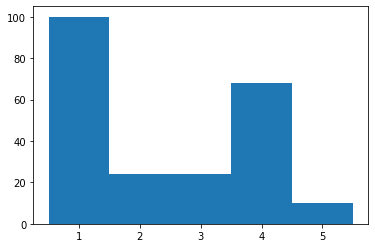

[1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 1 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 4 4 4 4 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 2 2]


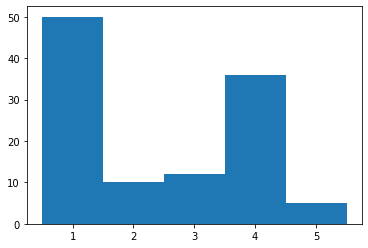

[1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 3 3 3 3 3 3 4 4 4 4 3 3 3 1 4 4 4
 4 5 5 5 5 5 4 4 4 4 3 3 3 5 5 5 5 5 2 2 4 4 4 4 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4]


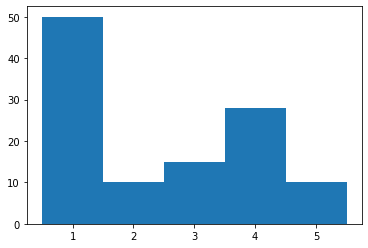

In [19]:
for ddf in [df_train, df_validation, df_test]:
    s = 'images_per_patient_in_split'
    ddf[s] = ddf.PID.groupby(ddf.PID).transform('count')
    x = ddf[s].to_numpy()
    print(x)
    data = x
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    plt.show()

Text(0.5, 1.0, 'patient index by dataset split (multiple images with the same patient index are placed in the same split)')

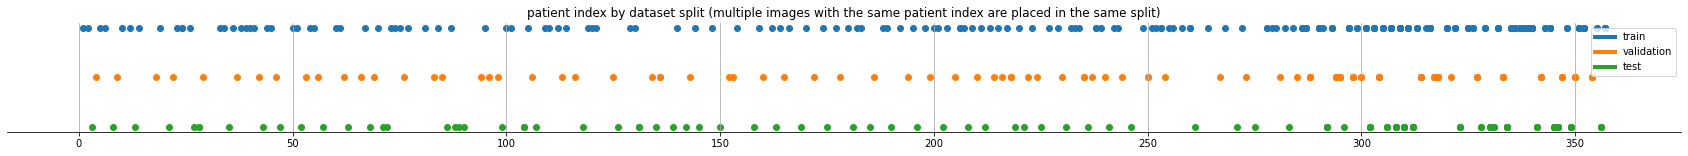

In [20]:
from matplotlib.lines import Line2D

cmap = plt.get_cmap("tab10")

pid_train = df_train.PID.to_numpy()
pid_validation = df_validation.PID.to_numpy()
pid_test = df_test.PID.to_numpy()

plt.figure(figsize=(30, 2))
plt.scatter(pid_train, np.repeat(-1, len(pid_train)))
plt.scatter(pid_validation, np.repeat(-2, len(pid_validation)))
plt.scatter(pid_test, np.repeat(-3, len(pid_test)))
plt.yticks([], [])
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x')

custom_lines = [Line2D([0], [0], color=cmap(0), lw=4),
                Line2D([0], [0], color=cmap(1), lw=4),
                Line2D([0], [0], color=cmap(2), lw=4)]

ax.legend(custom_lines, ['train', 'validation', 'test'])
plt.title('patient index by dataset split (multiple images with the same patient index are placed in the same split)')

In [21]:
print(len(train), len(validation), len(test))

226 113 113


In [22]:
assert train == ['BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_107_114_X13Y4_219_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_121_100_X15Y5_252_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_122_166_X15Y4_231_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_128_177_X16Y5_254_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_92_239_X11Y3_165_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_99_159_X12Y4_211_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_113_33_X14Y6_34_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_126_40_X16Y7_130_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_95_255_X12Y8_142_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_48_268_X6Y7_93_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_55_129_X7Y8_179_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_63_203_X8Y8_189_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_72_256_X9Y7_132_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_73_227_X9Y6_50_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_79_101_X10Y8_205_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_80_55_X10Y7_144_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_81_234_X10Y6_64_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_87_41_X11Y8_213_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_88_60_X11Y7_157_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_53_24_X6Y2_58_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_61_284_X7Y2_72_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_62_238_X7Y1_4_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_70_238_X8Y1_16_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_74_280_X9Y5_223_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_82_220_X10Y5_229_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_17_206_X2Y2_85_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_24_61_X3Y4_207_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_25_45_X3Y3_161_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_44_24_X5Y2_124_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_8_206_X1Y2_70_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170912_7_282_X1Y3_258_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_11_2_X2Y8_159_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_12_44_X2Y7_95_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_2_14_X1Y8_146_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_30_38_X4Y7_122_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_31_211_X4Y6_52_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_38_112_X5Y8_181_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_3_39_X1Y7_81_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_19_249_X3Y9_54_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_113_279_X14Y6_163_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_114_264_X14Y5_138_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_126_162_X16Y7_331_a0_full.tiff', 'BaselTMA_SP42_19.8kx12.535ky_7000x6500_7_20179015_109_253_X13Y2_33_a0_full.tiff', 'BaselTMA_SP42_19.8kx12.535ky_7000x6500_7_20179015_117_253_X14Y2_126_a0_full.tiff', 'BaselTMA_SP42_19.8kx12.535ky_7000x6500_7_20179015_123_74_X15Y3_223_a0_full.tiff', 'BaselTMA_SP42_19.8kx12.535ky_7000x6500_7_20179015_124_251_X15Y2_199_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_71_164_X9Y8_86_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_72_223_X9Y7_65_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_73_174_X9Y6_41_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_81_109_X10Y6_135_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_82_188_X10Y5_110_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_87_121_X11Y8_281_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_95_12_X12Y8_358_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_96_73_X12Y7_346_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_98_54_X12Y5_305_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_86_105_X10Y1_98_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_91_81_X11Y4_269_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_94_6_X11Y1_196_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_40_148_X5Y6_38_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_41_189_X5Y5_15_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_55_198_X7Y8_278_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_57_232_X7Y6_229_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_64_5_X8Y7_343_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_66_192_X8Y5_302_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_43_70_X5Y3_50_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_44_120_X5Y2_27_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_45_36_X5Y1_6_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_59_154_X7Y4_242_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_62_84_X7Y1_193_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_22_183_X3Y6_275_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_2_182_X1Y8_80_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_30_258_X4Y7_364_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_3_229_X1Y7_59_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_4_130_X1Y6_35_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_5_10_X1Y5_12_a0_full.tiff', 'BaselTMA_SP42_39.8kx13.885ky_7000x7000_2_20179015_16_217_X2Y3_117_a0_full.tiff', 'BaselTMA_SP42_39.8kx13.885ky_7000x7000_2_20179015_27_215_X3Y1_166_a0_full.tiff', 'BaselTMA_SP42_39.8kx13.885ky_7000x7000_2_20179015_8_51_X1Y2_24_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_14_144_X16Y1_301_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_27_95_X13Y2_27_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_29_19_X15Y2_216_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_43_243_X13Y3_42_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_61_87_X15Y4_259_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_76_201_X14Y5_174_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_78_26_X16Y5_379_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_101_213_X7Y7_66_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_104_140_X10Y7_244_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_119_119_X9Y8_201_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_87_200_X9Y6_162_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_89_195_X11Y6_286_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_41_272_X11Y3_235_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_55_260_X10Y4_153_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_56_260_X9Y4_57_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_74_34_X12Y5_376_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_9_209_X11Y1_192_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_19_180_X5Y2_21_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_5_50_X7Y1_189_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_100_252_X6Y7_382_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_111_1_X1Y8_45_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_116_77_X3Y8_177_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_79_207_X1Y6_15_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_83_242_X5Y6_304_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_17_278_X3Y2_207_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_18_278_X4Y2_313_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_33_170_X3Y3_229_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_64_75_X2Y5_165_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_107_233_X13Y7_108_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_108_67_X14Y7_226_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_109_23_X15Y7_289_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_124_110_X14Y8_247_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_257_2_Cy1x1_18_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_258_2_Cy1x2_36_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_261_37_Cy1x5_70_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_262_37_Cy1x6_78_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_264_37_Cy1x8_94_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_271_52_Cy2x7_154_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_273_52_Cy3x1_173_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_274_52_Cy3x2_181_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_278_14_Cy3x6_213_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_279_14_Cy3x7_221_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_281_66_Cy4x1_229_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_282_66_Cy4x2_237_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_283_66_Cy4x3_245_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_284_66_Cy4x4_253_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_301_18_Cy6x5_359_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_302_18_Cy6x6_367_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_303_18_Cy6x7_375_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_304_18_Cy6x8_383_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_311_59_Cy7x7_440_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_312_59_Cy7x8_448_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_313_59_Cy8x1_456_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_314_59_Cy8x2_464_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_326_22_Cy9x6_79_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_327_22_Cy9x7_87_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_328_22_Cy9x8_95_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_329_22_Cy10x1_103_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_331_54_Cy10x3_117_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_332_54_Cy10x4_131_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_334_54_Cy10x6_147_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_335_54_Cy10x7_155_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_349_63_Cy12x5_262_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_350_63_Cy12x6_270_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_353_8_Cy13x1_295_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_355_8_Cy13x3_312_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_357_8_Cy13x5_328_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_363_28_Cy14x3_376_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_366_28_Cy14x6_401_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_368_28_Cy14x8_417_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_369_41_Cy15x1_425_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_370_41_Cy15x2_433_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_372_41_Cy15x4_457_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_129_16_By1x1_12_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_130_24_By1x2_30_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_131_24_By1x3_48_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_132_24_By1x4_60_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_133_24_By1x5_68_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_178_40_By7x2_414_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_180_40_By7x4_430_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_182_40_By7x6_446_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171127_135_24_By1x7_524_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_214_53_By11x6_196_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_215_53_By11x7_204_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_216_53_By11x8_212_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_217_53_By12x1_220_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_225_70_By13x1_285_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_226_70_By13x2_293_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_235_72_By14x3_366_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_236_72_By14x4_374_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_237_72_By14x5_382_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_238_72_By14x6_391_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_245_35_By15x5_447_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_246_35_By15x6_455_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_247_35_By15x7_463_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_249_35_By16x1_479_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_255_2_By16x7_517_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171127_203_30_By10x3_525_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_1_5_Ay1x1_6_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_22_26_Ay3x6_193_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_23_26_Ay3x7_201_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_24_26_Ay3x8_209_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_25_26_Ay4x1_217_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_2_5_Ay1x2_24_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_30_6_Ay4x6_249_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_37_20_Ay5x5_306_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_38_20_Ay5x6_315_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_39_20_Ay5x7_323_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_3_5_Ay1x3_42_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_40_20_Ay5x8_331_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_42_44_Ay6x2_347_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_44_44_Ay6x4_363_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_47_51_Ay6x7_387_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_48_51_Ay6x8_396_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_49_51_Ay7x1_404_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_4_5_Ay1x4_58_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_50_51_Ay7x2_412_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_52_31_Ay7x4_428_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_53_31_Ay7x5_436_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_54_31_Ay7x6_444_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_55_31_Ay7x7_452_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_100_58_Ay13x4_299_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_101_58_Ay13x5_307_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_103_12_Ay13x7_324_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_104_12_Ay13x8_332_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_105_12_Ay14x1_340_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_106_12_Ay14x2_348_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_108_67_Ay14x4_364_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_109_67_Ay14x5_372_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_110_67_Ay14x6_380_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_111_67_Ay14x7_388_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_125_16_Ay16x5_485_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_126_16_Ay16x6_492_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_127_16_Ay16x7_499_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_67_47_Ay9x3_45_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_68_47_Ay9x4_59_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_69_47_Ay9x5_67_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_70_47_Ay9x6_75_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_82_50_Ay11x2_170_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_84_50_Ay11x4_186_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_85_50_Ay11x5_194_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_87_55_Ay11x7_210_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_88_55_Ay11x8_218_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_89_55_Ay12x1_226_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_90_55_Ay12x2_234_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_92_55_Ay12x4_250_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_93_1_Ay12x5_258_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_94_1_Ay12x6_266_a0_full.tiff']

In [23]:
assert validation == ['BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_106_18_X13Y5_248_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_114_42_X14Y5_250_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_117_83_X14Y2_128_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_103_267_X13Y8_155_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_120_214_X15Y6_48_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_127_237_X16Y6_62_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_47_53_X6Y8_169_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_56_62_X7Y7_108_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_57_37_X7Y6_22_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_89_254_X11Y6_78_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_58_153_X7Y5_209_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_83_218_X10Y4_193_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_43_69_X5Y3_183_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_51_186_X6Y4_227_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_75_218_X9Y4_240_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_83_218_X10Y4_244_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_20_134_X3Y8_171_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_21_224_X3Y7_110_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_40_165_X5Y6_66_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_4_216_X1Y6_12_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_10_106_X2Y9_40_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_46_9_X6Y9_97_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_104_178_X13Y7_89_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_105_76_X13Y6_44_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_106_160_X13Y5_21_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_120_152_X15Y6_260_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_80_46_X10Y7_160_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_90_98_X11Y5_208_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_76_96_X9Y3_53_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_77_240_X9Y2_30_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_78_136_X9Y4_74_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_83_136_X10Y4_172_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_48_273_X6Y7_157_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_56_285_X7Y7_254_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_61_29_X7Y2_217_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_13_56_X2Y6_154_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_14_113_X2Y5_129_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_32_210_X4Y5_352_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_45_4_X15Y3_238_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_102_281_X8Y7_126_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_105_194_X11Y7_307_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_106_94_X12Y7_367_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_90_22_X12Y6_349_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_23_172_X9Y2_24_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_25_235_X11Y2_213_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_26_235_X12Y2_319_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_73_230_X11Y5_277_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_7_85_X9Y1_9_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_21_222_X7Y2_210_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_70_199_X8Y5_373_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_81_205_X3Y6_159_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_99_125_X5Y7_325_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_16_143_X2Y2_111_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_1_244_X3Y1_186_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_31_250_X1Y3_33_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_32_250_X2Y3_129_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_50_116_X4Y4_352_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_93_66_X15Y6_268_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_306_33_Cy7x2_400_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_307_33_Cy7x3_408_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_308_33_Cy7x4_416_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_309_33_Cy7x5_424_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_316_19_Cy8x4_480_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_317_19_Cy8x5_488_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_318_19_Cy8x6_495_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_319_19_Cy8x7_502_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_321_13_Cy9x1_21_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_322_13_Cy9x2_39_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_323_13_Cy9x3_55_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_324_13_Cy9x4_63_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_342_57_Cy11x6_214_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_343_57_Cy11x7_222_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_344_57_Cy11x8_230_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_345_57_Cy12x1_238_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_146_48_By3x2_163_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_148_48_By3x4_179_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_149_48_By3x5_187_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_151_48_By3x7_203_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_152_9_By3x8_211_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_154_9_By4x2_227_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_155_9_By4x3_235_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_157_9_By4x5_251_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_175_36_By6x7_390_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_188_32_By8x4_478_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_190_32_By8x6_493_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_194_62_By9x2_33_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_195_62_By9x3_51_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_196_62_By9x4_61_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_204_10_By10x4_115_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_205_10_By10x5_123_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_206_10_By10x6_129_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_207_10_By10x7_137_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_220_29_By12x4_244_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_221_29_By12x5_252_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_222_29_By12x6_260_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_223_29_By12x7_268_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_224_29_By12x8_277_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_232_15_By13x8_342_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_233_15_By14x1_350_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_250_65_By16x2_487_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_252_65_By16x4_501_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_253_65_By16x5_508_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_32_69_Ay4x8_265_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_33_69_Ay5x1_274_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_34_69_Ay5x2_282_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_35_69_Ay5x3_290_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_7_42_Ay1x7_82_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_8_42_Ay1x8_90_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_9_42_Ay2x1_98_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_72_3_Ay9x8_91_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_73_3_Ay10x1_99_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_74_3_Ay10x2_105_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_75_3_Ay10x3_113_a0_full.tiff']

In [24]:
assert test == ['BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_123_86_X15Y3_203_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_90_88_X11Y5_242_a0_full.tiff', 'BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20170905_94_72_X11Y1_6_a0_full.tiff', 'BaselTMA_SP41_15.475kx17.66ky_8000x5000_11_20170905_112_126_X14Y7_106_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_64_219_X8Y7_120_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170905_65_57_X8Y6_36_a0_full.tiff', 'BaselTMA_SP41_23.475kx17.66ky_10000x5000_12_20170912_49_231_X6Y6_256_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_66_135_X8Y5_217_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_67_104_X8Y4_175_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_77_52_X9Y3_126_a0_full.tiff', 'BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_20170905_78_68_X9Y1_30_a0_full.tiff', 'BaselTMA_SP41_33.475kx12.66ky_8500x8500_2_20170905_67_104_X8Y4_233_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_13_283_X2Y6_24_a0_full.tiff', 'BaselTMA_SP41_33.475kx17.665ky_8500x5000_13_20170905_39_196_X5Y7_134_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_1_212_X1Y9_26_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_28_63_X4Y9_68_a0_full.tiff', 'BaselTMA_SP41_331.8kx19.665ky_10000x2000_15_20170905_37_8_X5Y9_83_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_119_208_X15Y7_284_a0_full.tiff', 'BaselTMA_SP42_19.78kx19.035ky_6500x7000_13_20179015_121_175_X15Y5_235_a0_full.tiff', 'BaselTMA_SP42_19.8kx12.535ky_7000x6500_7_20179015_129_35_X16Y4_319_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_74_190_X9Y5_18_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_88_236_X11Y7_257_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_89_261_X11Y6_232_a0_full.tiff', 'BaselTMA_SP42_25.78kx19.535ky_7000x7000_12_20179015_97_158_X12Y6_328_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_101_28_X12Y2_316_a0_full.tiff', 'BaselTMA_SP42_26.8kx12.885ky_7000x7000_6_20179015_93_28_X11Y2_220_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_38_13_X5Y8_83_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_39_99_X5Y7_62_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_49_27_X6Y6_132_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_50_181_X6Y5_107_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_58_185_X7Y5_205_a0_full.tiff', 'BaselTMA_SP42_32.435kx20.41ky_7000x7000_11_20179015_63_71_X8Y8_355_a0_full.tiff', 'BaselTMA_SP42_32.8kx13.885ky_7000x8000_5_20179015_42_275_X5Y4_71_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_1_163_X1Y9_104_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_20_169_X3Y8_322_a0_full.tiff', 'BaselTMA_SP42_39.025kx22410ky_7000x8500_8_20179015_31_89_X4Y6_361_a0_full.tiff', 'BaselTMA_SP42_39.8kx13.885ky_7000x7000_2_20179015_6_145_X1Y4_68_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_50_131_X14Y4_156_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_59_131_X13Y4_60_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_62_47_X16Y4_361_a0_full.tiff', 'BaselTMA_SP43_10.3kx13.7ky_6500x8000_6_20170928_75_118_X13Y5_81_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_121_271_X11Y8_328_a0_full.tiff', 'BaselTMA_SP43_15.9kx19.3ky_10000x5500_10_20170928_85_90_X7Y6_48_a0_full.tiff', 'BaselTMA_SP43_16.3kx14.5ky_7000x8000_5_20170928_71_202_X9Y5_78_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_35_150_X5Y3_36_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_37_241_X7Y3_232_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_3_142_X5Y1_6_a0_full.tiff', 'BaselTMA_SP43_22.8kx15ky_7000x8000_4_20170928_67_43_X5Y5_75_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_126_225_X2Y9_141_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_80_246_X2Y6_84_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_95_139_X1Y7_30_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_96_221_X2Y7_102_a0_full.tiff', 'BaselTMA_SP43_25.8kx22ky_10500x6500_8_20170928_98_107_X4Y7_241_a0_full.tiff', 'BaselTMA_SP43_29.3kx15.5ky_7000x8000_3_20170928_65_21_X3Y5_271_a0_full.tiff', 'BaselTMA_SP43_9.9kx19.3ky_6000x5500_11_20170928_91_3_X13Y6_69_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_266_7_Cy2x2_108_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_267_7_Cy2x3_116_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_268_7_Cy2x4_130_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_269_7_Cy2x5_138_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_291_23_Cy5x3_278_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_292_23_Cy5x4_286_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_293_23_Cy5x5_294_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_294_23_Cy5x6_302_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_296_21_Cy5x8_319_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_298_21_Cy6x2_335_a0_full.tiff', 'ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171115_299_21_Cy6x3_343_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_336_27_Cy10x8_166_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_337_27_Cy11x1_174_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_338_27_Cy11x2_182_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_339_27_Cy11x3_190_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_341_27_Cy11x5_206_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_358_60_Cy13x6_336_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_359_60_Cy13x7_344_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_360_60_Cy13x8_352_a0_full.tiff', 'ZTMA208_slide_13.25kx21.95ky_7000x7000_9_20171115_361_60_Cy14x1_360_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_137_56_By2x1_92_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_138_56_By2x2_100_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_139_56_By2x3_106_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_141_49_By2x5_122_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_142_49_By2x6_128_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_143_49_By2x7_136_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_144_49_By2x8_144_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_145_49_By3x1_152_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_158_38_By4x6_259_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_159_38_By4x7_267_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_160_38_By4x8_276_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_168_11_By5x8_333_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_185_46_By8x1_454_a0_full.tiff', 'ZTMA208_slide_20.73kx15.16ky_7000x7000_6_20171115_186_46_By8x2_462_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_209_45_By11x1_153_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_210_45_By11x2_164_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_212_45_By11x4_180_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_240_25_By14x8_407_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_241_25_By15x1_415_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_242_25_By15x2_423_a0_full.tiff', 'ZTMA208_slide_20.73kx22.16ky_7000x7000_7_20171115_243_25_By15x3_431_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_17_64_Ay3x1_158_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_18_64_Ay3x2_161_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_20_64_Ay3x4_177_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_21_64_Ay3x5_185_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_57_17_Ay8x1_468_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_58_17_Ay8x2_476_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_59_17_Ay8x3_484_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_60_17_Ay8x4_491_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_62_61_Ay8x6_505_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_63_61_Ay8x7_512_a0_full.tiff', 'ZTMA208_slide_28.23kx15.4ky_7000x7000_4_20171115_64_61_Ay8x8_516_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_114_71_Ay15x2_397_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_116_71_Ay15x4_413_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_118_71_Ay15x6_429_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_65_61_Ay9x1_9_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_79_43_Ay10x7_143_a0_full.tiff', 'ZTMA208_slide_28.23kx22.4ky_7000x7000_5_20171115_80_43_Ay10x8_151_a0_full.tiff']